In [2]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(tibble))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(stringr))
library(parallel)
library(reshape2)
source('/home//workspace/IHA_Figure_Revision/helper_function/helper_function_IHA.r')

In [3]:
color_annotation<-read.csv('/home/workspace/IHA_Figure_Revision/Color_hex_codes/Cell_Type_Color_Annotation_and_Order.csv')
color_annotation$label<-gsub(" cell",'',color_annotation$label)
color_vector <- setNames(color_annotation$color, color_annotation$label)

In [4]:
meta_data=read.csv("sample_meta_data.csv")

In [5]:
meta_data<-meta_data %>% filter(age<=90)

In [6]:
meta_data$pbmc_sample_id<-meta_data$donor_id

In [7]:
#meta_data<-meta_data %>% arrange(Donor_id,Age) %>% distinct(Donor_id, .keep_all = TRUE)

In [8]:
file_list<-paste0("sample_normalized_count_average/", meta_data$pbmc_sample_id, ".csv")

In [9]:
df_list<-read_pseudobulk_expression(file_list,mc_cores = 25)

[1] "Total reading time: 63.106 seconds"
[1] "The length of the list matches the length of the input path."


In [25]:
deseq2_result_Y1D0<-read.csv('/home//workspace/IHA_Figure_Revision/Figure1/02_DEG/Deseq2_Result_Y1D0.csv')

In [26]:
# filter significant genes 
deseq2_result_Y1D0_AgeGroup_sig<-deseq2_result_Y1D0 %>% 
  filter(contrast == "cohort.cohortGuid") %>%
  filter(padj < 0.05, 
         abs(log2FoldChange) > 0.1)

In [27]:
df_degs_counts<-as.data.frame(table(deseq2_result_Y1D0_AgeGroup_sig$celltype,
                                    deseq2_result_Y1D0_AgeGroup_sig$Direction))

In [28]:
df_degs_counts_filtered<-df_degs_counts %>% filter(Var2=="HigherInBR2") %>% arrange(Var1)   %>% filter(Freq>20)

In [29]:
df_degs_counts_filtered

Var1,Var2,Freq
<fct>,<fct>,<int>
CM CD4 T cell,HigherInBR2,104
CM CD8 T cell,HigherInBR2,82
Core naive CD4 T cell,HigherInBR2,183
Core naive CD8 T cell,HigherInBR2,111
GZMB- CD27+ EM CD4 T cell,HigherInBR2,34
GZMB- CD27- EM CD4 T cell,HigherInBR2,33
GZMK+ CD27+ EM CD8 T cell,HigherInBR2,34
Naive CD4 Treg,HigherInBR2,89


In [30]:
score_df_list <- mclapply(unique(df_degs_counts_filtered$Var1), function(celltype_single) {
    top_n <- 100
    Direction_of_DEG <- "HigherInBR2"
    
    selected_genes <- deseq2_result_Y1D0_AgeGroup_sig %>%
        filter(celltype == celltype_single, Direction == Direction_of_DEG) %>%
        arrange(padj, desc(abs(log2FoldChange))) %>%
        slice_head(n = top_n) %>% 
        select(gene) %>%
        pull()
    selected_genes<-intersect(selected_genes,rownames(df_list[[1]]))
    print(length(selected_genes))
    long_format <- filter_genes_and_celltype(df_list, selected_genes, celltype_single, longformat = TRUE) %>%
        left_join(meta_data) %>%
        filter(!is.na(Mean_Expression)) %>%
        group_by(Gene) %>%
        mutate(Z_score_Mean_Expression = scale(Mean_Expression)) %>%
        ungroup()
    
    composite_score_df <- long_format %>%
        group_by(pbmc_sample_id) %>%
        summarise(
            composite_score_sum_mean = sum(Mean_Expression, na.rm = TRUE),
            composite_score_sum_scaled_mean = sum(Z_score_Mean_Expression, na.rm = TRUE)
        ) %>%
        left_join(meta_data) %>%
        mutate(celltype = celltype_single) %>%
        as.data.frame()
    
    return(composite_score_df)
}, mc.cores = 10)


In [31]:
composite_score_df_all<-do.call(rbind,score_df_list)

In [32]:
write.csv(composite_score_df_all,'Onek1K_CompositeScore_Up.csv')

In [33]:
df_degs_counts_filtered<-df_degs_counts %>% filter(Var2=="HigherInBR1") %>% arrange(Var1)   %>% filter(Freq>20)

In [34]:
score_df_list <- mclapply(unique(df_degs_counts_filtered$Var1), function(celltype_single) {
    top_n <- 100
    Direction_of_DEG <- "HigherInBR1"
    
    selected_genes <- deseq2_result_Y1D0_AgeGroup_sig %>%
        filter(celltype == celltype_single, Direction == Direction_of_DEG) %>%
        arrange(padj, desc(abs(log2FoldChange))) %>% 
        slice_head(n = top_n) %>%
        select(gene) %>%
        pull()
    selected_genes<-intersect(selected_genes,rownames(df_list[[1]]))
    long_format <- filter_genes_and_celltype(df_list, selected_genes, celltype_single, longformat = TRUE) %>%
        left_join(meta_data) %>%
        filter(!is.na(Mean_Expression)) %>%
        group_by(Gene) %>%
        mutate(Z_score_Mean_Expression = scale(Mean_Expression)) %>%
        ungroup()
    
    composite_score_df <- long_format %>%
        group_by(pbmc_sample_id) %>%
        summarise(
            composite_score_sum_mean = sum(Mean_Expression, na.rm = TRUE),
            composite_score_sum_scaled_mean = sum(Z_score_Mean_Expression, na.rm = TRUE)
        ) %>%
        left_join(meta_data) %>%
        mutate(celltype = celltype_single) %>%
        as.data.frame()
    
    return(composite_score_df)
}, mc.cores = 8)



Joining with `by = join_by(pbmc_sample_id)`
Joining with `by = join_by(pbmc_sample_id)`
Warning message in FUN(X[[i]], ...):
“Cell type CM CD8 T cell not found in the dataframe.”
Warning message in FUN(X[[i]], ...):
“Cell type CM CD8 T cell not found in the dataframe.”
Joining with `by = join_by(pbmc_sample_id)`
Joining with `by = join_by(pbmc_sample_id)`
Joining with `by = join_by(pbmc_sample_id)`
Joining with `by = join_by(pbmc_sample_id)`
Warning message in FUN(X[[i]], ...):
“Cell type Core naive CD8 T cell not found in the dataframe.”
Joining with `by = join_by(pbmc_sample_id)`
Joining with `by = join_by(pbmc_sample_id)`
Joining with `by = join_by(pbmc_sample_id)`
Joining with `by = join_by(pbmc_sample_id)`
Warning message in FUN(X[[i]], ...):
“Cell type GZMB- CD27- EM CD4 T cell not found in the dataframe.”
Warning message in FUN(X[[i]], ...):
“Cell type GZMB- CD27- EM CD4 T cell not found in the dataframe.”
Warning message in FUN(X[[i]], ...):
“Cell type GZMB- CD27- EM CD4 T cell

In [35]:
composite_score_df_all<-do.call(rbind,score_df_list)

In [36]:
write.csv(composite_score_df_all,'Onek1K_CompositeScore_Down.csv')


# Visualization

In [37]:
df<-read.csv('Onek1K_CompositeScore_Down.csv')

In [38]:
df$celltype<-gsub(" cell",'',df$celltype)

In [39]:
df <- df %>% group_by(celltype)%>%
  arrange(desc(age))%>%
  mutate(label = ifelse(row_number() == 1 & 
                        age == max(age), 
                        as.character(celltype), 
                        NA_character_))

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
Warning message:
“Removed 40 rows containing non-finite values (`stat_smooth()`).”


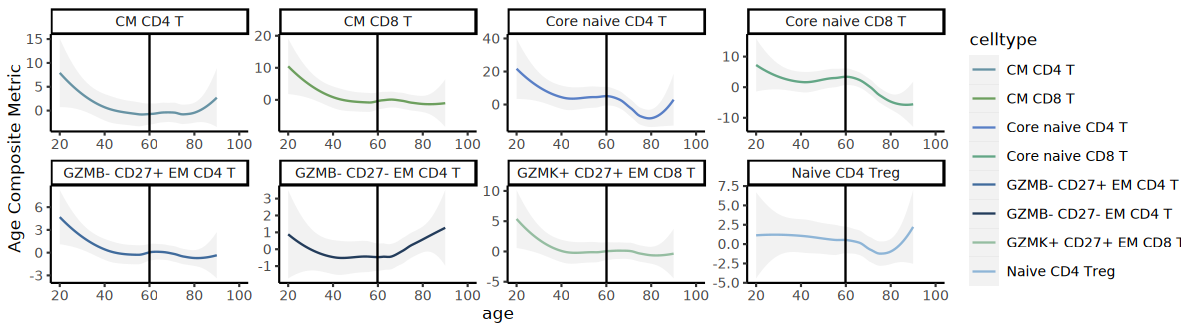

In [40]:
options(repr.plot.width = 250/25.4, repr.plot.height = 70/25.4)

p <- ggplot(data = df, aes(x = age, 
                           y = composite_score_sum_scaled_mean, label=celltype,color = celltype, group = celltype)) +
  geom_smooth(se = TRUE, fill = "#E0E0E0", span = 0.8,
              linewidth = 0.5) +
  theme_classic(base_size = 6) +
  scale_color_manual(values = color_vector)  +
  theme_classic(base_size = 10) +
 geom_vline(xintercept = 60)+ylab("Age Composite Metric") +facet_wrap(~celltype,scale='free',ncol=4)+scale_x_continuous(limits = c(20, 100))

p

In [41]:
df<-read.csv('Onek1K_CompositeScore_Up.csv')

In [42]:
df$celltype<-gsub(" cell",'',df$celltype)

In [43]:
df <- df %>% group_by(celltype)%>%
  arrange(desc(age))%>%
  mutate(label = ifelse(row_number() == 1 & 
                        age == max(age), 
                        as.character(celltype), 
                        NA_character_))

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
Warning message:
“Removed 40 rows containing non-finite values (`stat_smooth()`).”


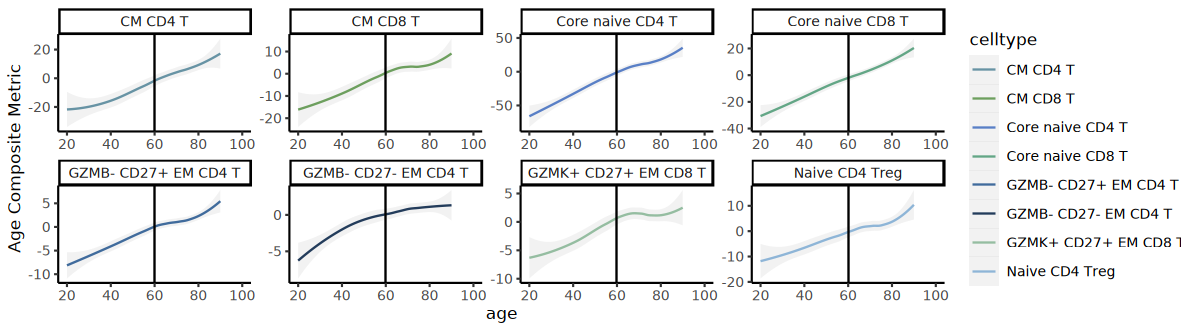

In [44]:
options(repr.plot.width = 250/25.4, repr.plot.height = 70/25.4)

p <- ggplot(data = df, aes(x = age, 
                           y = composite_score_sum_scaled_mean, label=celltype,color = celltype, group = celltype)) +
  geom_smooth(se = TRUE, fill = "#E0E0E0", span = 0.8,
              linewidth = 0.5) +
  theme_classic(base_size = 6) +
  scale_color_manual(values = color_vector)  +
  theme_classic(base_size = 10) +
 geom_vline(xintercept = 60)+ylab("Age Composite Metric") +facet_wrap(~celltype,scale='free',ncol=4)+scale_x_continuous(limits = c(20, 100))

p